# ARIMA modeling

In [4]:
# import libraries
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [15]:
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [5]:
# import datasets
cases_df = pd.read_csv('../clean_data/Cases_Normalized_per_100k.csv')
cases_df.head()

,county,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,date,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,population,confirmedper100k,newlyconfirmedper100k,deathper100k,newdeath100k,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,7dayrollingavg_newlyconfirmed_rawnumber,7dayrollingavg_newdeath_rawnumber
0,Alameda,29.0,0.0,29,0,2020-03-18,0.019,0.008,0.055,0.123,0.795,1671329,1.735146,1.735146,0.000000,0.000000,NaN,NaN,NaN,NaN
1,Alameda,36.0,0.0,7,0,2020-03-19,0.019,0.008,0.055,0.123,0.795,1671329,2.153974,0.418828,0.000000,0.000000,NaN,NaN,NaN,NaN
2,Alameda,42.0,0.0,6,0,2020-03-20,0.019,0.008,0.055,0.123,0.795,1671329,2.512970,0.358996,0.000000,0.000000,NaN,NaN,NaN,NaN
3,Alameda,62.0,0.0,20,0,2020-03-21,0.019,0.008,0.055,0.123,0.795,1671329,3.709623,1.196652,0.000000,0.000000,NaN,NaN,NaN,NaN
4,Alameda,72.0,1.0,10,1,2020-03-22,0.019,0.008,0.055,0.123,0.795,1671329,4.307949,0.598326,0.059833,0.059833,NaN,NaN,NaN,NaN


In [80]:
cases_df.describe()

,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,population,confirmedper100k,newlyconfirmedper100k,deathper100k,newdeath100k,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,7dayrollingavg_newlyconfirmed_rawnumber,7dayrollingavg_newdeath_rawnumber
count,1.812400e+04,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,1.812400e+04,18124.000000,18124.000000,18124.000000,18124.000000,17776.000000,1.777600e+04,17776.000000,17776.000000
mean,1.327444e+04,210.774443,173.013187,2.048003,0.032279,0.030699,0.063650,0.158545,0.714792,6.823606e+05,1542.530785,20.284986,19.606417,0.210988,20.232502,2.081917e-01,172.290086,2.001583
std,5.201773e+04,852.430551,814.985729,11.017366,0.028533,0.026178,0.033898,0.040410,0.092762,1.456208e+06,2084.332897,43.944282,28.624650,0.831238,31.417552,4.040341e-01,775.800926,9.438015
min,0.000000e+00,0.000000,-1157.000000,-16.000000,0.001000,0.000000,0.004000,0.058000,0.482000,1.129000e+03,0.000000,-74.546183,0.000000,-5.543545,-6.977150,-7.919349e-01,-1.142857,-1.428571
25%,9.400000e+01,1.000000,1.000000,0.000000,0.015000,0.013000,0.040000,0.134000,0.661000,4.590500e+04,99.646385,0.606875,1.002456,0.000000,2.049615,1.522592e-15,2.000000,0.000000
50%,1.044000e+03,15.000000,14.000000,0.000000,0.023000,0.023000,0.058000,0.156000,0.737000,1.928430e+05,711.532789,6.700781,8.138623,0.000000,8.310360,5.983262e-02,18.285714,0.142857
75%,8.147250e+03,114.000000,85.000000,0.000000,0.043000,0.043000,0.084000,0.186000,0.786000,7.621480e+05,2248.121154,22.165620,27.829294,0.000000,24.251025,2.301092e-01,89.464286,1.000000
max,1.048757e+06,15260.000000,28549.000000,318.000000,0.140000,0.135000,0.162000,0.276000,0.889000,1.003911e+07,15791.711641,1860.053144,272.052534,27.717723,566.793296,6.335479e+00,15711.142857,241.285714


In [6]:
# convert date to datetime
cases_df['date'] = pd.to_datetime(cases_df['date'])

In [7]:
# drop no longer needed columns
cases_df.drop(['totalcountconfirmed', 'totalcountdeaths', 'newcountconfirmed',
              'newcountdeaths', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 
              'ALWAYS', 'deathper100k', 'newdeath100k', 'confirmedper100k', 'population',
               'newlyconfirmedper100k' ,'7dayrollingavg_newlyconfirmed_rawnumber', '7dayrollingavg_newdeath_rawnumber'], 
             axis = 1, inplace = True)
cases_df.head()

,county,date,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath
0,Alameda,2020-03-18,NaN,NaN
1,Alameda,2020-03-19,NaN,NaN
2,Alameda,2020-03-20,NaN,NaN
3,Alameda,2020-03-21,NaN,NaN
4,Alameda,2020-03-22,NaN,NaN


In [8]:
hospitals_df = pd.read_csv('../clean_data/hospitals_by_county.csv')
hospitals_df.head()

,county,todays_date,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds
0,Plumas,2020-03-29,0.0,1.0,1.0,NaN,0.0,1.0,NaN
1,Tehama,2020-03-29,0.0,0.0,0.0,308.0,0.0,0.0,2.0
2,Glenn,2020-03-29,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,Mono,2020-03-29,0.0,1.0,1.0,308.0,0.0,0.0,2.0
4,Marin,2020-03-29,7.0,13.0,20.0,493.0,2.0,6.0,11.0


In [9]:
hospitals_df['todays_date'] = pd.to_datetime(hospitals_df['todays_date'])

In [10]:
hospitals_df.drop(['hospitalized_covid_confirmed_patients', 'hospitalized_suspected_covid_patients', 
                   'icu_covid_confirmed_patients', 'icu_suspected_covid_patients'],
                 axis = 1, inplace = True)
hospitals_df.head()

,county,todays_date,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
0,Plumas,2020-03-29,1.0,NaN,NaN
1,Tehama,2020-03-29,0.0,308.0,2.0
2,Glenn,2020-03-29,0.0,NaN,NaN
3,Mono,2020-03-29,1.0,308.0,2.0
4,Marin,2020-03-29,20.0,493.0,11.0


In [11]:
cases_hosp_df = cases_df.merge(hospitals_df, how = 'inner', left_on = ['county','date'], right_on = ['county', 'todays_date'])
cases_hosp_df.head()

,county,date,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,todays_date,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
0,Alameda,2020-03-29,1.153915,0.042738,2020-03-29,127.0,2725.0,119.0
1,Alameda,2020-03-30,1.384698,0.051285,2020-03-30,148.0,3283.0,146.0
2,Alameda,2020-03-31,1.478721,0.042738,2020-03-31,150.0,1857.0,77.0
3,Alameda,2020-04-01,1.307770,0.042738,2020-04-01,128.0,2456.0,106.0
4,Alameda,2020-04-02,1.478721,0.051285,2020-04-02,133.0,2580.0,112.0


In [12]:
# do a group by so we can create predictions per county
county_df = cases_hosp_df.groupby(['county', 'date']).mean()

In [88]:
county_df.index.get_level_values('county').unique()[0]

'Alameda'

In [89]:
# start by analyzing LA County
county_df.loc['Los Angeles']

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
date,,,,,
2020-03-29,2.468916,0.048382,1621.0,7394.0,345.0
2020-03-30,2.957007,0.056920,1878.0,9688.0,456.0
2020-03-31,3.369679,0.059766,1952.0,9460.0,445.0
2020-04-01,3.951689,0.079688,2071.0,10431.0,492.0
2020-04-02,4.219214,0.086803,2088.0,10349.0,488.0
...,...,...,...,...,...
2021-01-20,110.458032,2.033476,7413.0,19392.0,236.0
2021-01-21,97.337912,2.002170,7226.0,19411.0,274.0
2021-01-22,88.508157,1.999324,7014.0,19377.0,281.0


## Pilot modeling using Los Angeles

In [90]:
county_df.loc['Los Angeles']

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
date,,,,,
2020-03-29,2.468916,0.048382,1621.0,7394.0,345.0
2020-03-30,2.957007,0.056920,1878.0,9688.0,456.0
2020-03-31,3.369679,0.059766,1952.0,9460.0,445.0
2020-04-01,3.951689,0.079688,2071.0,10431.0,492.0
2020-04-02,4.219214,0.086803,2088.0,10349.0,488.0
...,...,...,...,...,...
2021-01-20,110.458032,2.033476,7413.0,19392.0,236.0
2021-01-21,97.337912,2.002170,7226.0,19411.0,274.0
2021-01-22,88.508157,1.999324,7014.0,19377.0,281.0


In [13]:
la_df = county_df.loc['Los Angeles'].tail(110)
features = ['hospitalized_covid_patients', '7dayrollingavg_newdeath', 'all_hospital_beds', 'icu_available_beds']
X = la_df[features]
y = la_df[['7dayrollingavg_newlyconfirmed']]

In [16]:

X_train = X.iloc[:92]
X_test = X.iloc[92:]
y_train = y.iloc[:92]
y_test = y.iloc[92:]
X_train.tail()

,hospitalized_covid_patients,7dayrollingavg_newdeath,all_hospital_beds,icu_available_beds
date,,,,
2021-01-02,7971.0,1.770220,20244.0,327.0
2021-01-03,8203.0,1.837101,20328.0,326.0
2021-01-04,8318.0,1.842793,20371.0,338.0
2021-01-05,8422.0,1.834255,20495.0,313.0
2021-01-06,8385.0,1.810064,20435.0,328.0


In [21]:
%pip install pmdarima

     |████████████████████████████████| 610 kB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 86.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 80.1 MB/s eta 0:00:01
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0
Note: you may need to restart the kernel to use updated packages.


In [22]:
import pmdarima as pm

In [24]:
smodel = pm.auto_arima(y_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=None, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=575.359, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=649.159, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=611.739, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=647.160, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=576.989, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=576.229, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=574.601, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=576.291, Time=0.05 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=577.940, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=572.608, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=575.638, Time=0.37 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=574.247, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=574.308, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=573.362, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   92
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -283.304
Date:                Thu, 28 Jan 2021   AIC                            572.608
Time:                        13:57:53   BIC                            580.108
Sample:                             0   HQIC                           575.632
                                 - 92                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1881      0.052    -22.821      0.000      -1.290      -1.086
ma.L2          0.2782      0.064      4.331      0.000       0.152       0.404
sigma2        30.9945      2.022     15.330      0.000      27.032      34.957
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               298.43
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              34.47   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

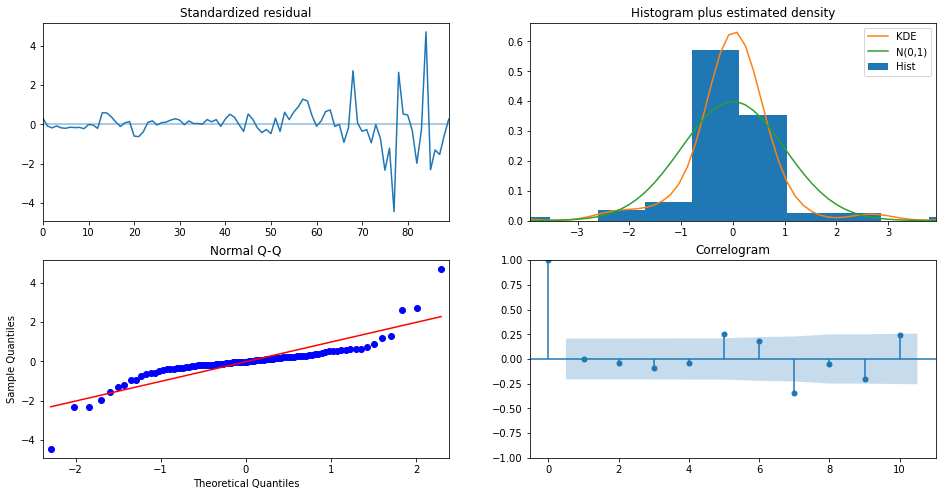

In [36]:
smodel.plot_diagnostics(figsize=(16, 8))
plt.show()

                                    ARIMA Model Results                                     
Dep. Variable:     D2.7dayrollingavg_newlyconfirmed   No. Observations:                   90
Model:                               ARIMA(0, 2, 2)   Log Likelihood                -283.300
Method:                                     css-mle   S.D. of innovations              5.567
Date:                              Thu, 28 Jan 2021   AIC                            574.601
Time:                                      17:37:19   BIC                            584.600
Sample:                                  10-09-2020   HQIC                           578.633
                                       - 01-06-2021                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                     

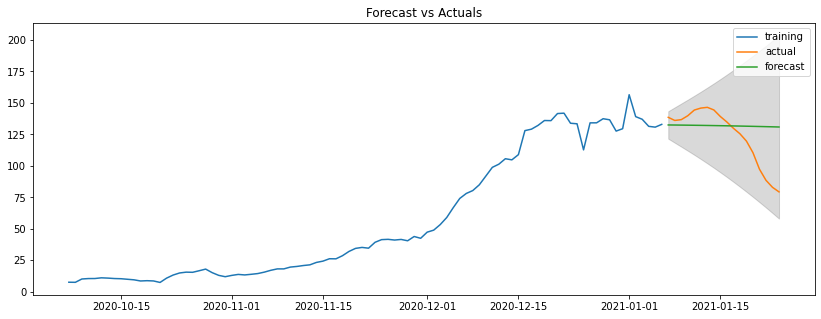

In [71]:


warnings.filterwarnings("ignore") 

model = ARIMA(y_train, order=smodel.order)  
fitted = model.fit(disp=-1)  
print(fitted.summary())
# Forecast
fc, se, conf = fitted.forecast(18, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=y_test.index)
lower_series = pd.Series(conf[:, 0], index=y_test.index)
upper_series = pd.Series(conf[:, 1], index=y_test.index)

# Plot
plt.figure(figsize=(14,5))
plt.plot(y_train, label='training')
plt.plot(y_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [35]:


print('MSE of our forecast is:', mean_squared_error(y_test, fc_series, squared=True))
print('RMSE of our forecast is:', mean_squared_error(y_test, fc_series, squared=False))

MSE of our forecast is: 524.1627103872607
RMSE of our forecast is: 22.894600026802408


In [38]:
smodel = pm.auto_arima(y, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=None, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=684.987, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=761.359, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=718.901, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=686.186, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=759.361, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=686.897, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=686.522, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=684.739, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=686.600, Time=0.05 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=687.512, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=683.386, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=684.809, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=685.147, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=685.232, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=683.6

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -338.693
Date:                Thu, 28 Jan 2021   AIC                            683.386
Time:                        14:12:10   BIC                            691.432
Sample:                             0   HQIC                           686.648
                                - 110                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0460      0.050    -21.016      0.000      -1.144      -0.948
ma.L2          0.1922      0.065      2.938      0.003       0.064       0.320
sigma2        30.5668      1.908     16.017      0.000      26.827      34.307
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               353.54
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              40.14   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

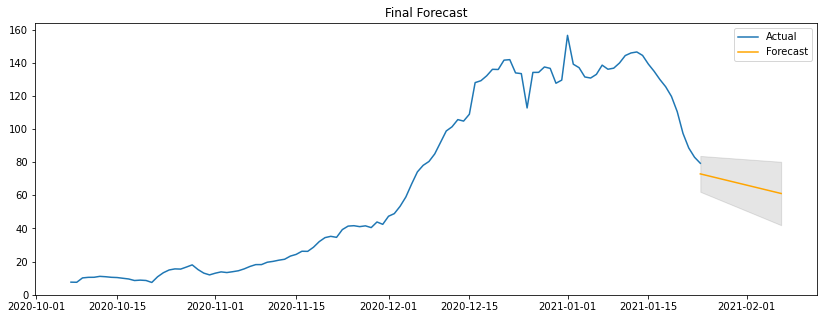

In [70]:
# Forecast
n_periods = 3
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(y.index[-1], periods=n_periods, freq='W')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot

fig = plt.figure(figsize=(14, 5))

plt.plot(y, label="Actual")
plt.plot(fitted_series, color='orange', label='Forecast')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.1)

plt.title('Final Forecast')
plt.legend()
plt.show()